<a href="https://colab.research.google.com/github/firstyudha/AVD/blob/main/AVD_netflix_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis and Visualization Netflix Reviews

In this notebook, we'll explore methods for analyzing text using Netflix Reviews data.

# Import packages

In [1]:
# google collab
from google.colab import drive

# data processing
import numpy as np
import pandas as pd

# text processing and NLP
import nltk
from textblob import TextBlob

# gensim for topic modeling
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# viz
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # Import the necessary module for Gensim visualization


# misc
import re
import warnings
warnings.filterwarnings("ignore")

# gdrive mounting
drive.mount("/content/drive", force_remount=True)

print('Packages successfully imported.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.0 MB/s eta 0:00:00
Mounted at /content/drive
Packages successfully imported.


# Load data

sumber data set : https://www.kaggle.com/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated/data

In [2]:
data_path = '/content/drive/My Drive/netflix_reviews.csv'

df = pd.read_csv(data_path)

jumlah = len(df)
variable = df.columns
tipe_data = df.dtypes
print(f"Jumlah data: {jumlah} \n Variable: {variable} \n Tipe Data: {tipe_data}")

df.head()

Jumlah data: 128975 
 Variable: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object') 
 Tipe Data: reviewId                object
userName                object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
appVersion              object
dtype: object


,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,df3ce408-eb30-4f8d-8274-a082dd388401,Mohammad Hasan,While Netflix excels in offering a wide range ...,2,0,8.141.1 build 13 51230,2025-02-14 14:59:44,8.141.1 build 13 51230
1,c1f247c5-0513-466c-94e6-3efcdf4bc270,Jaswinder Kaur,I am not able to solve the update problem,1,0,9.2.1 build 9 62116,2025-02-14 14:59:26,9.2.1 build 9 62116
2,ecdd6cec-536d-4303-92d8-993438eb85f0,sanjay acharya,Amazing🤘,5,0,NaN,2025-02-14 14:59:13,NaN
3,43cfee98-c142-4c0d-ae1b-bd56ce47ffa9,Vinez Vinez,It is faster n provides accurate information,5,0,NaN,2025-02-14 14:58:03,NaN
4,8adbf07c-cb0d-4e87-ba78-72a7717efbe2,Musonda Mwamba,Execcellent,5,0,8.143.1 build 11 52000,2025-02-14 14:31:23,8.143.1 build 11 52000


# Tahapan Analisa Data

**Pembersihan Data (Data Cleaning)**

In [3]:
def data_cleaning(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()  # remove leading/trailing whitespace
    return text

df['content_c'] = df['content'].apply(data_cleaning)
df.fillna('', inplace=True) #remove null data


**Eksplorasi Data (Exploratory Data Analysis - EDA) + Visualisasi Data**

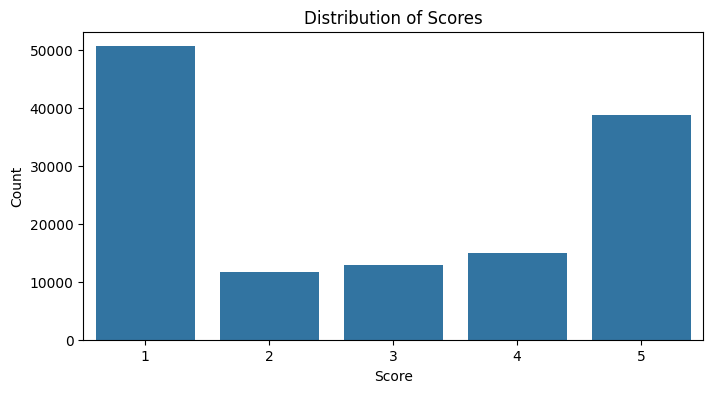

In [4]:
# analyzing score distribution
score_counts = df.score.value_counts().sort_index()
plt.figure(figsize=(8, 4))
sns.barplot(x=score_counts.index, y=score_counts.values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

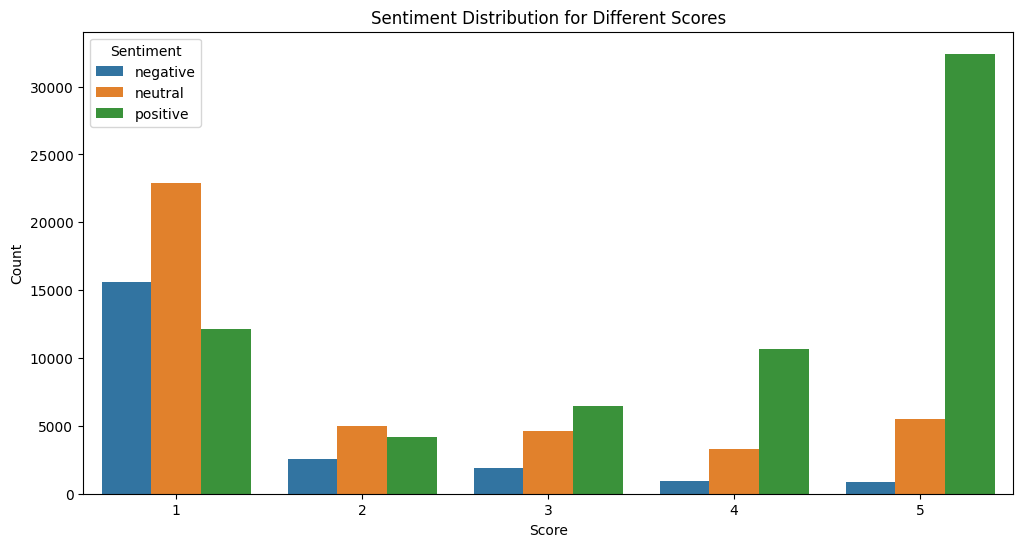

In [5]:
# sentiment distribution

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['content_c'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))
df[['content_c', 'score', 'sentiment_label']]

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='score', hue='sentiment_label')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Sentiment Distribution for Different Scores')
plt.legend(title='Sentiment')
plt.show()

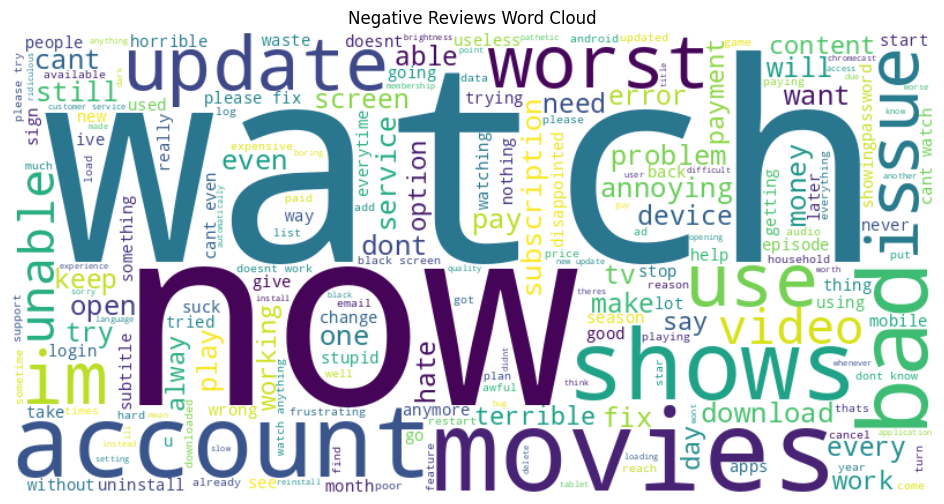

In [6]:
#Word cloud
#Analyzing negative reviews

stopwords = set(STOPWORDS)
stopwords.update(['netflix', 'movie', 'show', 'time', 'app', 'series', 'phone']) # creating a custom list based on domain knowledge

negative_reviews = ' '.join(df[df['sentiment_label'] == 'negative']['content_c'])

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(negative_reviews)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

**Intrepretasi Hasil**

In [11]:
# Topic Modeling, scope : negative reviews

# preprocess text data in content_c

def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()  # remove leading/trailing whitespace
    return text

def preprocess_text_data(text):
    tokens = [token for token in text.lower().split() if token.isalnum()] # tokenize text and remove stopwords
    return tokens

texts = [preprocess_text(text) for text in df[df['sentiment_label']=='negative']['content_c']]

print("Contoh topic yang menyebabkan review negatif:")
texts[:10]

Contoh topic yang menyebabkan review negatif:


['i am not able to solve the update problem',
 'bad',
 'very very worst app i have ever seen whenever we try to open it only shows loading i dont know why i pay for this app',
 'netflix sucks no good content and the accessibility controls always blocking my shows i want to watch',
 'bad you made forged to fight a bad experience now',
 'download videos cannot b played worst',
 'already unsubscribe last month and yet still get to pay for this month like seriously  the movie list is not complete after all',
 'since yesterday my netflix view speed is very slow ive cleared my storage and yet its still same thing honestly im tired of it',
 'pathetic app',
 'not working in my mobile this is a scan after the autopay recharge date it doesnt work for few days so we lost to avail these days when netflix isnt working is it a scam']

In [12]:
tokenized_texts = [simple_preprocess(text) for text in texts]
tokenized_texts = [[word for word in doc if word not in stopwords] for doc in tokenized_texts] # remove stopwords

# create dict and corpus
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_texts]

# LDA model
# Extract topics that cause dissastisfaction among users

# build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, passes=5, workers=2)

# print topics
topics = lda_model.print_topics(-1)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

Topic 0: 0.027*"download" + 0.016*"play" + 0.014*"movies" + 0.011*"work" + 0.011*"doesnt" + 0.011*"even" + 0.011*"loading" + 0.011*"tv" + 0.011*"bad" + 0.009*"available"
Topic 1: 0.026*"please" + 0.020*"open" + 0.019*"unable" + 0.018*"error" + 0.016*"fix" + 0.016*"cant" + 0.015*"try" + 0.012*"im" + 0.010*"working" + 0.010*"now"
Topic 2: 0.024*"watch" + 0.022*"screen" + 0.014*"cant" + 0.013*"black" + 0.012*"update" + 0.011*"dont" + 0.009*"want" + 0.009*"video" + 0.009*"please" + 0.009*"annoying"
Topic 3: 0.017*"cant" + 0.016*"shows" + 0.015*"movies" + 0.013*"watch" + 0.013*"password" + 0.012*"account" + 0.011*"im" + 0.010*"hate" + 0.008*"new" + 0.008*"dont"
Topic 4: 0.025*"payment" + 0.024*"bad" + 0.022*"worst" + 0.018*"money" + 0.015*"subscription" + 0.015*"service" + 0.012*"card" + 0.011*"customer" + 0.010*"experience" + 0.009*"will"


In [ ]:
# visualize topics
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Statistik Dasar

In [13]:
score_mean = df['score'].mean()
score_median = df['score'].median()
score_distribution = df['score'].describe()

print(f"Mean Score: {score_mean}")
print(f"Median Score: {score_median}")
print("Score Distribution:")
print(score_distribution)

Mean Score: 2.8419073463849585
Median Score: 3.0
Score Distribution:
count    128975.000000
mean          2.841907
std           1.718814
min           1.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           5.000000
Name: score, dtype: float64


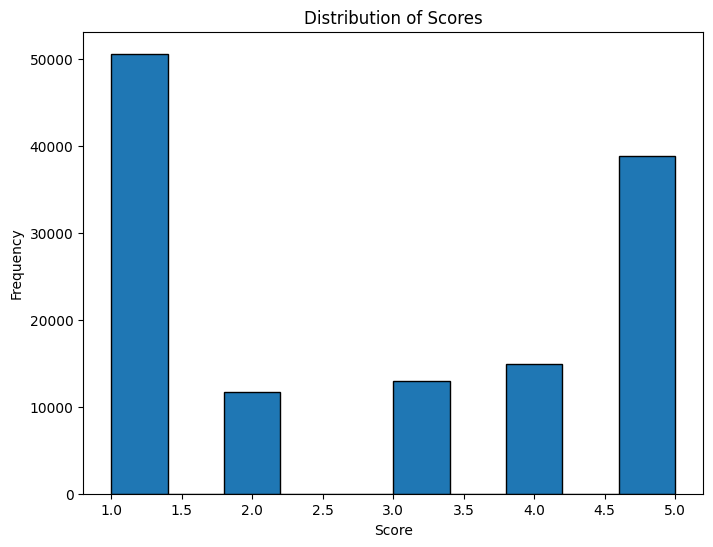

In [17]:
# Visualize the distribution using a histogram
plt.figure(figsize=(8, 6))
plt.hist(df['score'], bins=10, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()

# Identifikasi Outlier dan Missing Values

In [18]:
#Identify outliers using the IQR method
Q1 = df['score'].quantile(0.25)
Q3 = df['score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['score'] < lower_bound) | (df['score'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 0


Notes:

Why the outlier count is 0:

The IQR method identifies outliers based on the distribution of the data. In this case, the score column, which represents user ratings, likely has a distribution where all values fall within the calculated IQR bounds. This means that there are no values significantly far away from the central data points to be considered outliers according to this specific method.

What it means:

Data Distribution: The score data might be relatively clustered around the central tendency (mean or median) without extreme values pulling it in one direction or another. This could indicate a generally consistent pattern of user ratings.
IQR Method Limitations: The IQR method might not be sensitive enough to detect subtle outliers or outliers in specific regions of the data. Other outlier detection methods might be more suitable depending on the dataset's characteristics.
Context of Reviews: In the context of Netflix reviews, a score of 1 is the lowest and 5 is the highest. If there are no outliers, it could mean that users tend to provide ratings within a relatively limited range, without extreme positive or negative scores dominating the data.
Possible Scenarios:

True Absence of Outliers: The dataset might genuinely not have any extreme values. This is possible if user ratings are generally consistent and don't exhibit significant deviations.
Data Characteristics: The IQR method might not be sensitive enough to identify outliers in specific regions or distributions. For example, if the data is skewed or has multiple peaks, the IQR might miss certain outlier points.
Data Collection: The data collection process might have naturally filtered out extreme values. For instance, if users are less likely to provide very low or very high ratings, the dataset might not contain those extremes.
Recommendations:

Explore Data Visualization: Create box plots, histograms, and other visualizations to better understand the distribution of scores and potentially identify any subtle patterns or deviations.
Consider Other Outlier Detection Methods: Explore alternative methods like Z-score, modified Z-score, or local outlier factor (LOF) to detect outliers that the IQR method might miss.
Investigate Context: Consider the specific context of the Netflix Reviews dataset and the meaning of the score column. This can provide insights into whether the absence of outliers is reasonable or if further investigation is necessary.